# load data

In [1]:
import pandas as pd

df = pd.read_parquet('../results/kis_viability.parquet')

print('unique drugs:', df['drug'].nunique())
print('unique concs:', df['concentration_M'].nunique())
print('unique cell lines:', df['depmap_id'].nunique())

df

unique drugs: 168
unique concs: 8
unique cell lines: 480


,drug,concentration_M,depmap_id,viability,inh_AAK1,inh_ABL1,inh_ABL2,inh_ACVR1,inh_ACVR1B,inh_ACVR2B,...,inh_TGFBR2,inh_TNIK,inh_TNK1,inh_TNK2,inh_TP53RK,inh_TTK,inh_TYK2,inh_ULK1,inh_WEE1,inh_YES1
0,AC-480,3.000000e-09,ACH-000007,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,AC-480,3.000000e-09,ACH-000008,1.088750,1.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,AC-480,3.000000e-09,ACH-000011,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,AC-480,3.000000e-09,ACH-000012,1.298190,1.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,AC-480,3.000000e-09,ACH-000013,1.458047,1.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610843,Y-39983,3.000000e-05,ACH-001239,-0.038812,0.019503,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
610844,Y-39983,3.000000e-05,ACH-001306,1.784841,0.019503,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
610845,Y-39983,3.000000e-05,ACH-001307,1.000000,0.019503,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
610846,Y-39983,3.000000e-05,ACH-001318,1.876079,0.019503,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


# cv: leave one drug out

In [ ]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# X, y, and grouing
X = df.drop(columns=['drug', 'concentration_M',	'depmap_id', 'viability'])
y = df['viability']
groups = df['concentration_M']
logo = LeaveOneGroupOut()

# model
model = RandomForestRegressor(n_estimators = 10, n_jobs=-1)

# cross validation
scores = cross_val_score(model, X, y, groups=groups, cv=logo)

print('mean score:', scores.mean())
print('std score :', scores.std())

Cross-validation scores: [-5.09219348e-01 -1.84892414e-01 -1.23137589e-01 -2.65587618e-02
  1.99485702e-01  2.24107889e-01 -4.43967208e-01  2.80444542e-04]
Mean cross-validation score: -0.10798766062025907
Standard deviation of cross-validation score: 0.2507969686395555


In [ ]:
# manual cv
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import tqdm

# X, y, and grouing
X = df.drop(columns=['drug', 'concentration_M',	'depmap_id', 'viability'])
y = df['viability']
groups = df['concentration_M']
logo = LeaveOneGroupOut()

scores_manual = []
# loop
for train_index, test_index in tqdm.tqdm(logo.split(X, y, groups=groups), total=logo.get_n_splits(X, y, groups=groups)):
    # X, y
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

    # model
    model = RandomForestRegressor(n_estimators = 10, n_jobs=-1)
    model.fit(X_train, y_train)
    # predict
    y_pred = model.predict(X_test)

    # score
    score = model.score(X_test, y_test)
    scores_manual.append(score)

scores_manual = np.array(scores_manual)
print('mean score:', scores_manual.mean())
print('std score :', scores_manual.std())

# # add group
# group = []
# assert len(set(groups.iloc[test_index].values)) == 1
# group.append(groups.iloc[test_index].values[0])

100%|██████████| 8/8 [02:06<00:00, 15.81s/it]


cv:
	mean score: -0.10798766062025907
	std score : 0.2507969686395555
manual:
	mean score: -0.14048658465622327
	std score : 0.3094082399409156


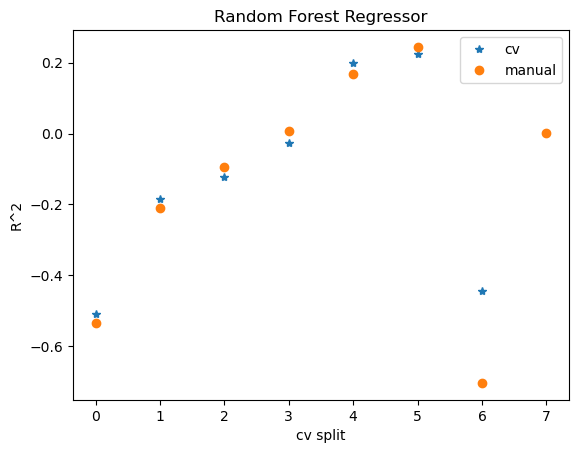

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# cv
print('cv:')
print('\tmean score:', scores.mean())
print('\tstd score :', scores.std())

# manual
scores_manual = np.array(scores_manual)
print('manual:')
print('\tmean score:', scores_manual.mean())
print('\tstd score :', scores_manual.std())

plt.plot(scores, '*', label='cv')
plt.plot(scores_manual, 'o', label='manual')
plt.xlabel('cv split')
plt.ylabel('R^2')
plt.title('Random Forest Regressor')
plt.legend()
plt.show()